In [1]:
using Pkg
Pkg.instantiate()
import TAMode
using Turing

┌ Info: Precompiling TAMode [294f26d0-a9c2-4f6a-959f-92a060cb6778]
└ @ Base loading.jl:1273


In [4]:
tpoints = 10.0 .^ range(-6.0, stop = 2.0, length = 10)

@model test(pYDataExp, surfDataExp, totDataExp, tps, g6conc, ::Type{TV}=Vector{Float64}) where {TV} = begin    
    paramsA ~ MvLogNormal(fill(-6.0, 2), 0.01)
    paramsB ~ Truncated(LogNormal(-1.0, 0.01), 0.0, 1.0)
    paramsC ~ MvLogNormal(fill(-6.0, 12), 0.01)
    scale ~ LogNormal(-1.0, 0.1)
    
    params = vcat(paramsA, paramsB, paramsC)

    #for index=1:size(g6conc)
        
    #data = TAMode.getAutocrine(params)
    data = TAMode.runTAM(tps, params, g6conc) #gas6 concentration
   
    #pY
    pYAXL = TAMode.pY .* TAMode.recpSpecific[1]
    pYData = data * pYAXL
    pYresids = pYDataExp .- pYData*scale #scale?
    pYresids ~ MvNormal(zeros(length(pYresids)), ones(length(pYresids))*std(pYresids))
    
    #surface
    surfAXL = TAMode.surface .* TAMode.recpSpecific[1]
    surfData = data * surfAXL
    surfresids = surfDataExp .- surfData*scale
    surfresids ~ MvNormal(zeros(length(surfresids)), ones(length(surfresids))*std(surfresids))
    
    #total
    totAXL = TAMode.total .* TAMode.recpSpecific[1]
    totData = data * totAXL
    totresids = totDataExp .- totData*scale
    totresids ~ MvNormal(zeros(length(totresids)), ones(length(totresids))*std(totresids))
    
end

(::DynamicPPL.ModelGen{(:pYDataExp, :surfDataExp, :totDataExp, :tps, :g6conc, :TV),var"###test#542",NamedTuple{(:TV,),Tuple{Type{Array{Float64,1}}}}}) (generic function with 1 method)

add model 
phospho and total
pyKE standard deviation of resids
run the sampler for 500 iterations, longer than 4 hours talk to Meyer
call summarize to summarize output, should look different from prior distribution
figure out what prior should be 

In [5]:
tps = [60.0, 240.0]; #tps in minutes 
pY = [10.75952427 8.305264139; 7.390399159 7.056438019; 7.144036441 7.680851079; 4.570826833 8.184089069; 6.107714557 7.204021903; 7.535575387 7.535575387];
surf = [0.206 0.239; 0.274 0.316; 0.281 0.251; 0.220 0.302; 0.256 0.281; 0.257 0.337];
tot = [3443.11 3219.69; 3143.41 3353.82; 3018.88 3611.82; 2608.88 3448.21; 2690.24 3168.14; 2672.00 2672.00]; 
GasConc = [64, 16, 4, 1, 0.25, 0.1];

print(surf[1,:])
# call sample in test with 1-5 iterations

[0.206, 0.239]

In [20]:
Pkg.add("Serialization")

 Resolving package versions...
  Updating `~/TAMode.jl/Project.toml`
 [no changes]
  Updating `~/TAMode.jl/Manifest.toml`
 [no changes]


In [24]:
using Test
using Profile
using Serialization
@testset "runTAM model" begin
    @profile testSamp = sample(test(pY[1,:], surf[1,:], tot[1,:], tps, GasConc[1]), HMC(0.01, 5), 1)
    r = Profile.retrieve();
    f = open("profile.bin", "w")
    serialize(f, r)
    close(f)
end

┌ Warning: The profile data buffer is full; profiling probably terminated
│ before your program finished. To profile for longer runs, call
│ `Profile.init()` with a larger buffer and/or larger delay.
└ @ Profile /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.3/Profile/src/Profile.jl:312


Test.DefaultTestSet("runTAM model", Any[], 0, false)

In [11]:
Profile.print()

┌ Warning: The profile data buffer is full; profiling probably terminated
│ before your program finished. To profile for longer runs, call
│ `Profile.init()` with a larger buffer and/or larger delay.
└ @ Profile /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.3/Profile/src/Profile.jl:312


1    ...ractinterpretation.jl:879; abstract_eval_call(::Array{Any,1},...
 1 ...tractinterpretation.jl:636; abstract_call(::Any, ::Array{Any,1}...
  1 ...tractinterpretation.jl:850; abstract_call(::Any, ::Array{Any,1...
   1 ...tractinterpretation.jl:93; abstract_call_gf_by_type(::Any, ::...
    1 ...ractinterpretation.jl:396; abstract_call_method(::Method, ::...
     1 ./compiler/typeinfer.jl:488; typeinf_edge(::Method, ::Any, ::C...
      1 ./compiler/typeinfer.jl:12; typeinf(::Core.Compiler.Inference...
       1 ...ctinterpretation.jl:1264; typeinf_nocycle(::Core.Compiler...
        1 ...ctinterpretation.jl:1208; typeinf_local(::Core.Compiler....
         1 ...ctinterpretation.jl:949; abstract_eval(::Any, ::Array{A...
          1 ...ctinterpretation.jl:879; abstract_eval_call(::Array{Any...
           1 ...tinterpretation.jl:636; abstract_call(::Any, ::Array{...
            1 ...tinterpretation.jl:850; abstract_call(::Any, ::Array...
             1 ...tinterpretation.jl:93; abstract_

Excessive output truncated after 524324 bytes.

                                   +336 12 ...ion.jl:396; abstract_ca...
                                   +337 12 ...fer.jl:488; typeinf_edg...
                                   +338 6 ...nfer.jl:12; typeinf(::Co...
                                   +339 6 ...ion.jl:1264; typeinf_noc...
                                   +340 6 ...ion.jl:1208; typeinf_loc...
                                   +341 6 ...tion.jl:949; abstract_eva...
                                   +342 6 ...tion.jl:877; abstract_eva...
                                   +343 6 ...tion.jl:21; abstract_cal...
                                   +344 6 ...tion.jl:50; abstract_cal...
                                   +345 6 ...tion.jl:838; _methods_by_...
                                   +338 5 ...nfer.jl:33; typeinf(::Co...
                                   +339 5 ...mize.jl:169; optimize(::C...
                                   +340 5 ...iver.jl:116; run_passes(:...
                                   +341 5 ...n

In [7]:
samp = sample(test(pY[1,:], surf[1,:], tot[1,:], tps), HMC(0.01, 5), 500)

MethodError: MethodError: no method matching ##test#542(::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1})
Closest candidates are:
  ##test#542(::Any, ::Any, ::Any, ::Any, !Matched::Any) at /home/sumedhak/.julia/packages/DynamicPPL/nsoCZ/src/compiler.jl:583
  ##test#542(::Any, ::Any, ::Any, ::Any, !Matched::Any, !Matched::Type{#s233} where #s233) at /home/sumedhak/.julia/packages/DynamicPPL/nsoCZ/src/compiler.jl:583

In [6]:
summarize(samp)

Summary Statistics

│ Row │ parameters  │ mean       │ std        │ naive_se    │ mcse        │
│     │ Symbol      │ Float64    │ Float64    │ Float64     │ Float64     │
├─────┼─────────────┼────────────┼────────────┼─────────────┼─────────────┤
│ 1   │ pYresids[1] │ 4.61656    │ 0.147451   │ 0.00659422  │ 0.0375505   │
│ 2   │ pYresids[2] │ -2.0157    │ 0.174526   │ 0.00780503  │ 0.0650665   │
│ 3   │ pYresids[3] │ -4.42116   │ 0.233154   │ 0.010427    │ 0.103627    │
│ 4   │ pYresids[4] │ -3.9975    │ 0.374422   │ 0.0167446   │ 0.154973    │
│ 5   │ pYresids[5] │ 3.65154    │ 0.269759   │ 0.012064    │ 0.110347    │
│ 6   │ paramsA[1]  │ 0.00247735 │ 2.67713e-5 │ 1.19725e-6  │ 3.30692e-6  │
│ 7   │ paramsA[2]  │ 0.00248179 │ 2.47115e-5 │ 1.10513e-6  │ 1.64604e-6  │
│ 8   │ paramsB     │ 0.367804   │ 0.00256103 │ 0.000114533 │ 0.000131267 │
│ 9   │ paramsC[1]  │ 0.00247872 │ 2.55007e-5 │ 1.14042e-6  │ 2.17503e-6  │
│ 10  │ paramsC[2]  │ 0.00248324 │ 2.51737e-5 │ 1.1258e-6   │ 1.4532

In [7]:
describe(samp)

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters  │ mean       │ std        │ naive_se    │ mcse        │
│     │ Symbol      │ Float64    │ Float64    │ Float64     │ Float64     │
├─────┼─────────────┼────────────┼────────────┼─────────────┼─────────────┤
│ 1   │ pYresids[1] │ 4.61656    │ 0.147451   │ 0.00659422  │ 0.0375505   │
│ 2   │ pYresids[2] │ -2.0157    │ 0.174526   │ 0.00780503  │ 0.0650665   │
│ 3   │ pYresids[3] │ -4.42116   │ 0.233154   │ 0.010427    │ 0.103627    │
│ 4   │ pYresids[4] │ -3.9975    │ 0.374422   │ 0.0167446   │ 0.154973    │
│ 5   │ pYresids[5] │ 3.65154    │ 0.269759   │ 0.012064    │ 0.110347    │
│ 6   │ paramsA[1]  │ 0.00247735 │ 2.67713e-5 │ 1.19725e-6  │ 3.30692e-6  │
│ 7   │ paramsA[2]  │ 0.00248179 │ 2.47115e-5 │ 1.10513e-6  │ 1.64604e-6  │
│ 8   │ paramsB     │ 0.367804   │ 0.00256103 │ 0.000114533 │ 0.000131267 │
│ 9   │ paramsC[1]  │ 0.00247872 │ 2.55007e-5 │ 1.14042e-6  │ 2.17503e-6  │
│ 

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %]  22.9 % [===============>                         ]  36.5 %50.0 %==========================>              ]  63.6 %]  77.1 % [=====================================>   ]  90.7 % Resolving package versions...
 Installed ArgCheck ──────────── v1.1.0
 Installed Adapt ─────────────── v1.0.1
 Installed Parsers ───────────── v0.3.11
 Installed FixedPointNumbers ─── v0.7.1
 Installed Ratios ────────────── v0.4.0
 Installed PlotUtils ─────────── v0.6.3
 Installed MacroTools ────────── v0.5.4
 Installed Optim ─────────────── v0.20.1
 Installed ArrayInterface ────── v2.4.1
 Installed DiffEqCallbacks ───── v2.12.0
 Installed RecursiveArrayTools ─ v2.1.0
 Installed FiniteDiff ────────── v2.2.0
 Installed AxisArrays ────────── v0.4.2
 Installed Requires ──────────── v1.0.1
 Installed GR ────────────────── v0.46.0

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273


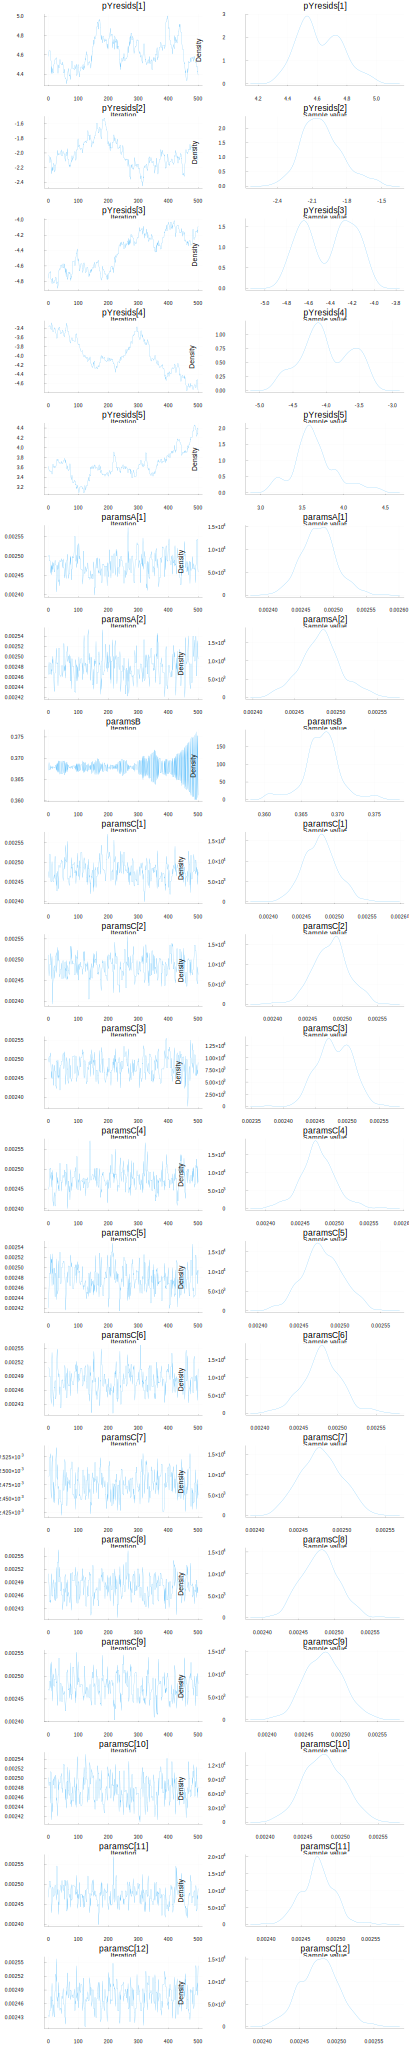

In [9]:
Pkg.add("StatsPlots");
using StatsPlots
plot(samp)